# TO DO:

* set up to read in pre-calculated spectral variables of all birds
* change negative Zeitgeber hours on x axis (Fig 4d)
* make line/errorbar plot of SWA across 24 hours? for NREM only?

# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import resin
import pandas as pd

from pandas import DataFrame,Series,read_table


General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 04/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsPath = './Fig 05/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)    
saveAsPath = './Fig 09/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)    
    
saveAsPath = './Fig 04/'   
saveAsName = 'Fig'

In [3]:
# Path to CSVs with epoch-by-epoch variables
var_path = './Epoch-by-epoch_variables/' 

In [4]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

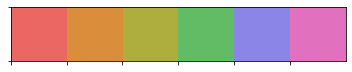

In [5]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

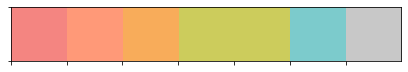

In [6]:
colors_video = sns.color_palette(np.array([[244,133,129],
                                           [255,153,120],
                                            [248,172,90],
                                            [204,204,92],
                                            [204,204,92],
                                            [124, 203, 204],
                                            [200, 200, 200]])
                                            /(255))

sns.palplot(colors_video)

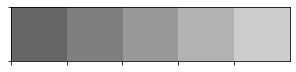

In [7]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


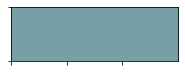

In [8]:
NREM_color = tuple(np.median(np.array([[97,188,101],
                                       [140,133,232]]),axis=0)/255)
sns.palplot(NREM_color)

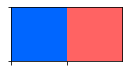

In [9]:
LD_color=[0, 102/255, 1]
LL_color=[1, 99/255, 99/255]

sns.palplot([LD_color, LL_color])

Plot-specific info

In [10]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [11]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Load formatted scores

In [12]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

In [13]:
AllScores_LL = {}
for b in birds_LL:
    bird_name = 'Bird ' + str(b+1) + 'LL'
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores_LL[bird_name] = data

### Convert video scores to numbers

In [14]:
# LL #
for b_num in birds_LL:

    b_name = 'Bird ' + str(b_num+1) + 'LL'
    Scores = AllScores_LL[b_name]
    # replace nan's with empty string
    Scores.fillna('', inplace=True)

    Label_num = -1 * np.ones_like(Scores['Video Label'])
    for st in range(len(stagesVideo)):
        stage_inds = [x for x in range(len(Scores['Epoch #'])) if stagesVideo[st] in Scores['Video Label'].iloc[x]]
        Label_num[stage_inds] = st

    # Preening/singing labels
    stage_inds = [x for x in range(len(Scores['Video Label']))
                  if ('p' in Scores['Video Label'].iloc[x])|('si' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 0

    # Unihem labels
    stage_inds = [x for x in range(len(Scores['Video Label'])) if ('g' in Scores['Video Label'].iloc[x])]
    Label_num[stage_inds] = 4

    # Save to dataframe
    AllScores_LL[b_name]['Video Label (#)'] = Label_num

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [15]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [16]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Load per-epoch variables

In [17]:
SleepVariables_raw = {}

for file in os.listdir(var_path):
    if file.endswith('.csv'):
        data = pd.read_csv(var_path + file, index_col=0)
        ch = file.split('_')[0].split('.')[0]   # get name of channel from filename
        
        SleepVariables_raw[ch] = data

In [18]:
EEGchannels = np.sort(list(SleepVariables_raw.keys()))
EEGchannels

array(['Bird 1: 4 LEEGf-Fgr', 'Bird 1: 5 LEEGf-LEEGp',
       'Bird 1: 6 LEEGm-LEEGp', 'Bird 1: 7 LEEGp-Fgr',
       'Bird 1: 8 REEGp-Fgr', 'Bird 1: 9 REEGp-LEEGp',
       'Bird 2: 4 LEEGf-Fgr', 'Bird 2: 5 LEEGf-LEEGm',
       'Bird 2: 6 LEEGm-LEEGp', 'Bird 2: 7 REEGf-Fgr',
       'Bird 2: 8 REEGm-Fgr', 'Bird 2: 9 REEGf-REEGm',
       'Bird 2LL: 4 LEEGf-Fgr', 'Bird 2LL: 5 LEEGf-LEEGm',
       'Bird 2LL: 6 LEEGm-LEEGp', 'Bird 2LL: 7 REEGf-Fgr',
       'Bird 2LL: 8 REEGm-Fgr', 'Bird 2LL: 9 REEGf-REEGm',
       'Bird 3: 4LEEGf-LEEGp', 'Bird 3: 5LEEGf-LEEGm',
       'Bird 3: 6LEEGm-LEEGp', 'Bird 3: 7REEGf-REEGp',
       'Bird 3: 8REEGf-REEGm', 'Bird 3: 9REEGm-REEGp',
       'Bird 3LL: 4LEEGf-LEEGp', 'Bird 3LL: 5LEEGf-LEEGm',
       'Bird 3LL: 6LEEGm-LEEGp', 'Bird 3LL: 7REEGf-REEGp',
       'Bird 3LL: 8REEGf-REEGm', 'Bird 3LL: 9REEGm-REEGp',
       'Bird 4: 4LEEGf-LEEGp', 'Bird 4: 5LEEGm-LEEGp',
       'Bird 4: 6LEEGm-LEEGf', 'Bird 4: 7REEGf-Fgr',
       'Bird 4: 8REEGf-REEGm', 'Bird 4: 9RE

## Pull out sleep data only, z-score variables

In [19]:
dont_z_score = ['Epoch', 'sleep scores', 'video scores', 'is sleep', 'is artifact']
                
z_score_but_keep_raw = ['nPeaks']

channels = np.sort(list(SleepVariables_raw.keys()))
SleepVariables = {}

for ch in channels:
    b = int(ch[5]) - 1
    
    raw_data = SleepVariables_raw[ch].copy()
    
    # get sleep data only
    sleep_data = raw_data[(raw_data['is sleep'] == 1)]
                          #(raw_data['is artifact'] == 0)] # exclude artifact, wake, drowsy, and US epochs
    
    # get nighttime data only
    #sleep_data = sleep_data[(sleep_data['Epoch']>lightsOffEp[b]) &
    #                        (sleep_data['Epoch']<lightsOnEp[b])]
    
    tmp_data = sleep_data.copy()
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data = tmp_data.drop(variable, axis=1) # don't zscore these things
    
    # Zscore
    #tmp_data = tmp_data.fillna(0) # fill in any NaNs with 0
    for col in tmp_data.columns.values:
        col_data = tmp_data[col]
        col_data[~np.isnan(col_data)] = stat.zscore(col_data[~np.isnan(col_data)])
        
        tmp_data[col] = col_data
        
    # Add back in non-z-scored variables e.g.g Epoch # and manual scores
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data[variable] = sleep_data[variable]
    
    for variable in z_score_but_keep_raw:
        if variable in sleep_data.columns.values:
            tmp_data[variable + ' raw'] = sleep_data[variable]
    
    SleepVariables[ch] = tmp_data
        

## Remove artifacts based on max amplitude

In [20]:
ampThres_SD = 4


for ch in SleepVariables.keys():
    ChannelVariables = SleepVariables[ch].copy()
    
    # pull out only sleep rows
    sleep_data = ChannelVariables[ChannelVariables["is sleep"]==1]
    sleep_data = sleep_data.fillna(0) # fill in any NaNs with 0
    
    # remove rows a certain #SDs above and below the mean
    # -- bc variables are already z-scored, this is easy
    sleep_data = sleep_data[sleep_data['max amp'].abs() < ampThres_SD]
    
    SleepVariables[ch] = sleep_data
    

## Load SWs and EMs

In [21]:
SWs_and_EMs = {}

for file in os.listdir(events_path):
    if file.endswith('.csv'):
        data = pd.read_csv(events_path + file, index_col=0)
        ch = file.split('_')[1].split('.')[0]   # get name of channel from filename
        
        if not 'LL' in ch: # exclude constant light data
            SWs_and_EMs[ch] = data
            

# Dot plots

In [22]:
saveMainPlot = True
savePlots = True

figsize = (9,10)
figsize_smaller = (6,8)
figsize_2variables = (8,9)
axis_label_fontsize = 24

# Dot formatting
alpha_main = 0.2
alpha_darker = 0.3


# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

## All variables for 1 channel

In [23]:
#variables = ["DeltaLog", "GammaDeltaRatio", "diffDeltaLog", "diffGammaDeltaRatio", "SD"]
variables = ["DeltaLog", "GammaDeltaRatio", "nPeaks raw"]

In [24]:
# Pick channel and bird
ch = "Bird 1: 5 LEEGf-LEEGp"
b = int(ch[5]) - 1

Text(0.5, 0.98, 'Bird 1: 5 LEEGf-LEEGp')

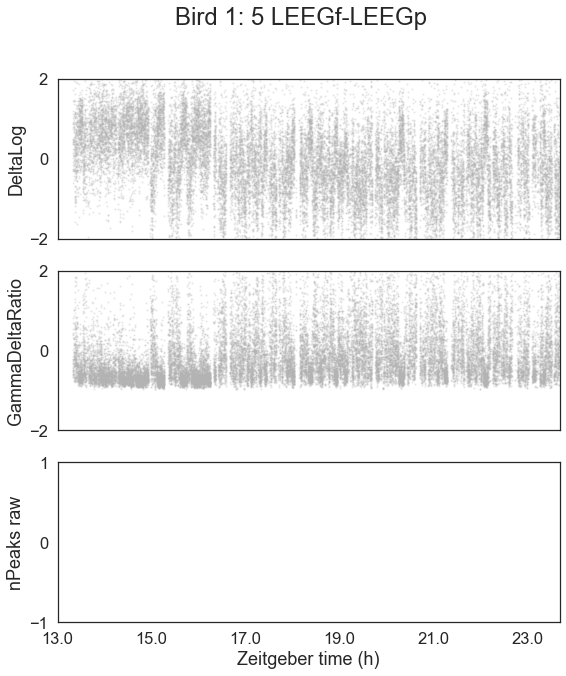

In [25]:
# All sleep stages grey; artifacts not plotted
stages = [3,4,5]

plt.figure(figsize=figsize)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        plot_color = [.7, .7, .7]
        
        plt.plot(tmp_Stage, '.', color=plot_color, alpha=alpha_main, markersize=2.5)
        if row < len(variables):
            plt.xticks([])
            plt.yticks([-2,0,2])
            plt.ylim((-2,2))
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
            plt.yticks([-1,0,1])
            plt.ylim((-1,1))
    row = row + 1
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.xlabel('Zeitgeber time (h)')
plt.suptitle(ch,fontsize=axis_label_fontsize)

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '5_allvariables_grey_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
#    plt.savefig(saveAsPath + saveAsName + '5_allvariables_grey_'+ ch[0:6] + '_' + ch[-11::] + '.tiff', dpi=300)


## FIGURE 5A: epoch-by-epoch

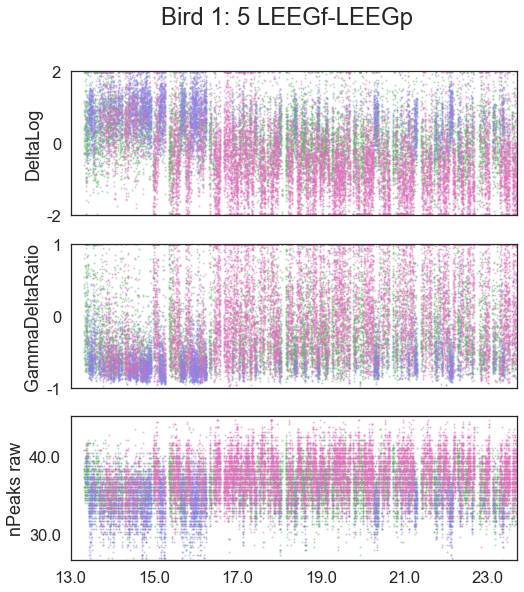

In [26]:
# Sleep stages in color
stages = [3, 4, 5]   # i, s, r

plt.figure(figsize=figsize_2variables)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage >= 0:
            plot_color = colors[stage]
        else:
            plot_color = [.7, .7, .7]
        
        if variable == 'GammaDeltaRatio':
            y_range=(-1,1) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
            
        # make sure dots that fall above/below y axis limits are plotted on axis
        tmp_Stage[tmp_Stage<(.99*y_range[0])] = .99*y_range[0]
        tmp_Stage[tmp_Stage>(.99*y_range[1])] = .99*y_range[1]
        
        plt.plot(tmp_Stage, '.', color=plot_color, alpha=.3, markersize=2.5)
        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
    row = row + 1
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.suptitle(ch,fontsize=axis_label_fontsize)

if savePlots:
    plt.savefig('./Fig 05/' + saveAsName + '5a_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
    plt.savefig('./Fig 05/' + saveAsName + '5a_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '.tiff', dpi=300)


### zoom in 

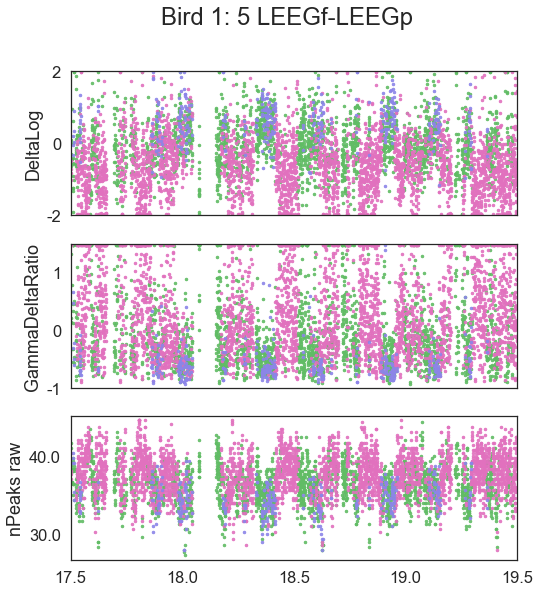

In [27]:
# Sleep stages in color
stages = [3, 5, 4]   # i, s, r

plt.figure(figsize=figsize_2variables)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage >= 0:
            plot_color = colors[stage]
        else:
            plot_color = [.7, .7, .7]
            
        if variable == 'GammaDeltaRatio':
            y_range=(-1,1.5) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
            
        # make sure dots that fall above/below y axis limits are plotted on axis
        tmp_Stage[tmp_Stage<(.99*y_range[0])] = .99*y_range[0]
        tmp_Stage[tmp_Stage>(.99*y_range[1])] = .99*y_range[1]

        
        plt.plot(tmp_Stage, '.', color=plot_color, alpha=.9, markersize=5)
        

        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],.5*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,.5))
    row = row + 1
    plt.xlim((lightsOffSec[b] + 4.5*3600, lightsOffSec[b] + 6.5*3600))
    plt.ylabel(variable)
    
plt.suptitle(ch,fontsize=axis_label_fontsize)

if savePlots:
    plt.savefig('./Fig 05/' + saveAsName + '5b_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '_closeup.pdf')
    plt.savefig('./Fig 05/' + saveAsName + '5b_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '_closeup.tiff', dpi=300)


## Smol histograms

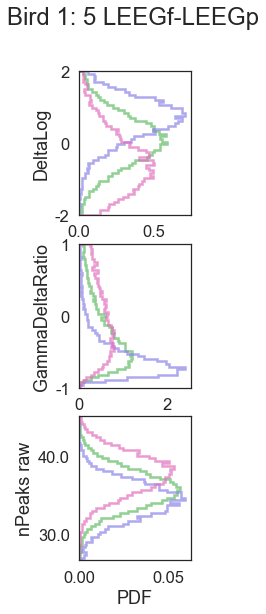

In [28]:
# Sleep stages in color
stages = [3, 4, 5]   # i, s, r

plt.figure(figsize=(2, figsize_2variables[1]))
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    
    if variable == 'GammaDeltaRatio':
        y_range=(-1,1) # z-score range for Delta/Gamma
        y_ticks=[-1,0,1]
        y_tick_labels=y_ticks
    elif variable == 'nPeaks raw':
        y_range=(80,135) # nPeaks not z-scored
        y_ticks=(90,120)
        y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
    else:
        y_range=(-2,2)
        y_ticks=[-2,0,2]
        y_tick_labels=y_ticks
    
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage >= 0:
            plot_color = colors[stage]
        else:
            plot_color = [.7, .7, .7]
        
        plt.hist(tmp_Stage.dropna(), color=plot_color, density=True, bins=55,
                 histtype='step', lw=linewidth/2, alpha=linealpha,
                 range=y_range,
                 orientation='horizontal')

    plt.ylim(y_range)
    plt.yticks(y_ticks, y_tick_labels)
        
    plt.ylim(y_range)
    plt.ylabel(variable)
    row = row + 1
    
plt.xlabel('PDF')
    
plt.suptitle(ch,fontsize=axis_label_fontsize)

if savePlots:
    plt.savefig('./Fig 05/' + saveAsName + '5a-right_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '_hist.pdf')


## Another bird

In [29]:
channelsToLoadEEG_best

[['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
 ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'],
 ['6LEEGm-LEEGp', '9REEGm-REEGp'],
 ['9REEGf-REEGp', '6LEEGm-LEEGf'],
 ['4LEEGf-LEEGp', '7REEGf-REEGp']]

In [30]:
# Pick channel and bird
ch = "Bird 4: 6LEEGm-LEEGf"
b = int(ch[5]) - 1

Text(0.5, 0.98, 'Bird 4: 6LEEGm-LEEGf')

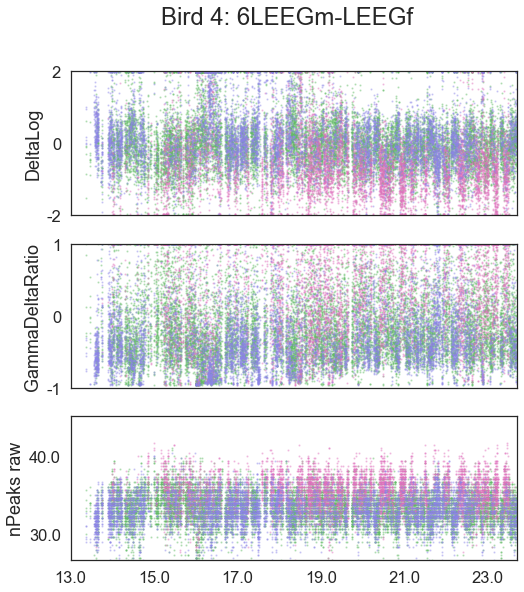

In [31]:
# Sleep stages in color
stages = [3, 5, 4]   # i, r, s

plt.figure(figsize=figsize_2variables)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage >= 0:
            plot_color = colors[stage]
        else:
            plot_color = [.7, .7, .7]
        
        if variable == 'GammaDeltaRatio':
            y_range=(-1,1) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
            
        # make sure dots that fall above/below y axis limits are plotted on axis
        tmp_Stage[tmp_Stage<(.99*y_range[0])] = .99*y_range[0]
        tmp_Stage[tmp_Stage>(.99*y_range[1])] = .99*y_range[1]
        
        plt.plot(tmp_Stage, '.', color=plot_color, alpha=.3, markersize=2.5)
        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
    row = row + 1
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.suptitle(ch,fontsize=axis_label_fontsize)

#if savePlots:
#    plt.savefig('./Fig 05/' + saveAsName + '5_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
#    plt.savefig('./Fig 05/' + saveAsName + '5_delta_and_gamma_sleepstages_'+ ch[0:6] + '_' + ch[-11::] + '.tiff', dpi=300)


## Separate dot plot for each stage

Text(0.5, 0.98, 'Bird 4: 6LEEGm-LEEGf')

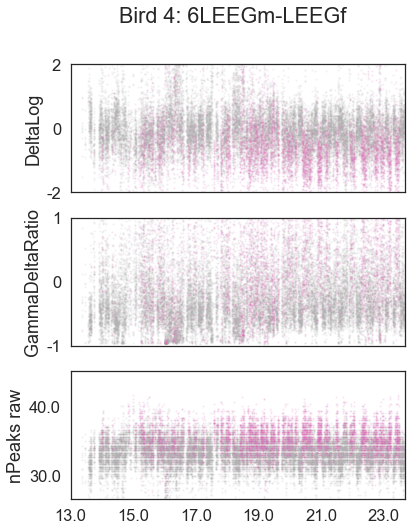

In [32]:
# One stage only in color; everything else grey; no artifacts or wake/drowsy plotted
# REM
stages = [3, 4, 5]   

plt.figure(figsize=figsize_smaller)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage == 5:
            plot_color = colors[stage]
            plot_alpha = .1
        else:
            plot_color = [.7, .7, .7]
            plot_alpha = .1
        
        plt.plot(tmp_Stage,'.', color=plot_color, alpha=plot_alpha, markersize=2.5)
        
        if variable == 'GammaDeltaRatio':
            y_range=(-1,1) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
            
    row = row + 1
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.suptitle(ch)

#if savePlots:
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_rem_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_rem_'+ ch[0:6] + '_' + ch[-11::] + '.tiff', dpi=300)


Text(0.5, 0.98, 'Bird 4: 6LEEGm-LEEGf')

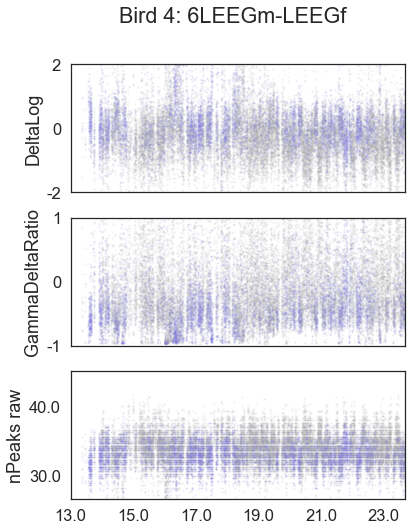

In [33]:
# One stage only in color; everything else grey; no artifacts or wake/drowsy plotted
# SWS
stages = [3, 5, 4]      # plot SWS last

plt.figure(figsize=figsize_smaller)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage == 4:
            plot_color = colors[stage]
            plot_alpha = .1
        else:
            plot_color = [.7, .7, .7]
            plot_alpha = .1
        
        plt.plot(tmp_Stage,'.', color=plot_color, alpha=plot_alpha, markersize=2.5)

        if variable == 'GammaDeltaRatio':
            y_range=(-1,1) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
            
    row = row + 1
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.suptitle(ch)

#if savePlots:
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_sws_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_sws_'+ ch[0:6] + '_' + ch[-11::] + '.tiff', dpi=300)


Text(0.5, 0.98, 'Bird 4: 6LEEGm-LEEGf')

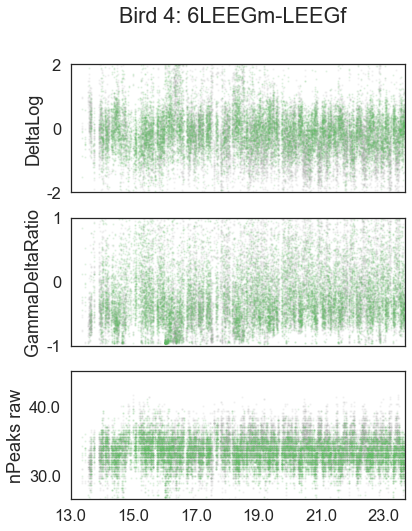

In [34]:
# One stage only in color; everything else grey; no artifacts or wake/drowsy plotted
# IS
stages = [2, 4, 5, 3]   # plot IS last

plt.figure(figsize=figsize_smaller)
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    bird_scores = SleepVariables[ch]["sleep scores"]
    for stage in stages:
        tmp_Stage = pd.Series(index=bird_scores.index)
        tmp_indStage = [x for x in bird_scores.index if bird_scores.loc[x]==stage]
        tmp_Stage.loc[tmp_indStage] = SleepVariables[ch][variable].loc[tmp_indStage]
        
        if stage == 3:
            plot_color = colors[stage]
            plot_alpha = .1
        else:
            plot_color = [.7, .7, .7]
            plot_alpha = .1
        
        plt.plot(tmp_Stage,'.', color=plot_color, alpha=plot_alpha, markersize=2.5)
        
        if variable == 'GammaDeltaRatio':
            y_range=(-1,1) # z-score range for Delta/Gamma
            y_ticks=[-1,0,1]
            y_tick_labels=y_ticks
        elif variable == 'nPeaks raw':
            y_range=(80,135) # nPeaks not z-scored
            y_ticks=(90,120)
            y_tick_labels = np.array(y_ticks)/3 # give nPeaks/s (3 s epochs)
        else:
            y_range=(-2,2)
            y_ticks=[-2,0,2]
            y_tick_labels=y_ticks
        
        plt.ylim(y_range)
        plt.yticks(y_ticks, y_tick_labels)
        
        if row < len(variables):
            plt.xticks([])
        else:
            plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],2*3600),
                       np.arange(np.floor(lightsOffZeit_hr[b]+24),24,2))
            
    row = row + 1

    plt.xlim((lightsOffSec[b],lightsOnSec[b]))
    plt.ylabel(variable)
    
plt.suptitle(ch)

#if savePlots:
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_is_'+ ch[0:6] + '_' + ch[-11::] + '.pdf')
#    plt.savefig('./Fig 05/' + saveAsName + '5_allvariables_is_'+ ch[0:6] + '_' + ch[-11::] + '.tiff',dpi=300)


# Totals by stage

## Stats across birds

In [35]:
grandmeans = pd.DataFrame([])
for variable in ['DeltaLog', 'GammaDeltaRatio', 'nPeaks']:
    print(variable)
        
    bird_means = pd.DataFrame([])
    
    for b_num in range(nBirds):
        b_name = 'Bird ' + str(b_num+1)
        Scores = AllScores[b_name]

        bird_Var_by_stage = pd.DataFrame([])

        for ch in channelsToLoadEEG[b_num]:

            ch_variables = SleepVariables[b_name + ': ' + ch].copy()

            bird_Var_by_stage[ch] = ch_variables.groupby(by='sleep scores').mean()[variable]
            
            
        bird_means['Bird ' + str(b_num + 1)] = bird_Var_by_stage.median(axis=1) # median across channels
        
    grandmeans[variable] = bird_means.mean(axis = 1) # mean across birds
    #grandmeans[variable] = bird_means.median(axis = 1) # median

            
    print(stat.f_oneway(bird_means.loc[3], bird_means.loc[4], bird_means.loc[5]))
    print('\t IS vs SWS', stat.ttest_rel(bird_means.loc[3], bird_means.loc[4]))
    print('\t IS vs REM', stat.ttest_rel(bird_means.loc[3], bird_means.loc[5]))
    print('\t SWS vs REM', stat.ttest_rel(bird_means.loc[4], bird_means.loc[5]))



DeltaLog
F_onewayResult(statistic=35.662628287393275, pvalue=8.921287157285299e-06)
	 IS vs SWS Ttest_relResult(statistic=-3.9781133670185382, pvalue=0.016426970440058034)
	 IS vs REM Ttest_relResult(statistic=6.73305789259309, pvalue=0.0025350697831073104)
	 SWS vs REM Ttest_relResult(statistic=5.624943422619119, pvalue=0.004912415412193559)
GammaDeltaRatio
F_onewayResult(statistic=43.27352405988423, pvalue=3.260061227118952e-06)
	 IS vs SWS Ttest_relResult(statistic=5.580608108557477, pvalue=0.005055223290579378)
	 IS vs REM Ttest_relResult(statistic=-5.650732075828042, pvalue=0.004831619457758468)
	 SWS vs REM Ttest_relResult(statistic=-7.748671406689181, pvalue=0.0014945016841629278)
nPeaks
F_onewayResult(statistic=71.73277291361232, pvalue=2.1148644671730183e-07)
	 IS vs SWS Ttest_relResult(statistic=3.8177652097521326, pvalue=0.01881431869727901)
	 IS vs REM Ttest_relResult(statistic=-10.144064697310199, pvalue=0.0005317137565618673)
	 SWS vs REM Ttest_relResult(statistic=-11.690

In [36]:
grandmeans

,DeltaLog,GammaDeltaRatio,nPeaks
sleep scores,,,
3.0,0.030091,-0.094520,-0.150945
4.0,0.307987,-0.314117,-0.412392
5.0,-0.372246,0.463307,0.698798


## FIGURE 4F-G: barplots of SWA and nPeaks

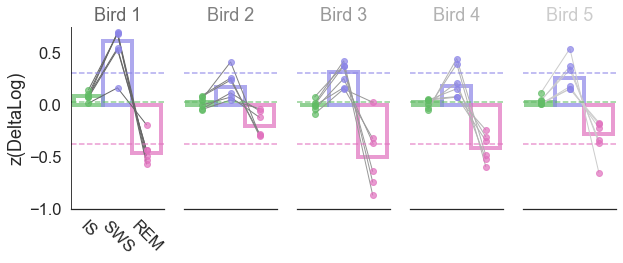

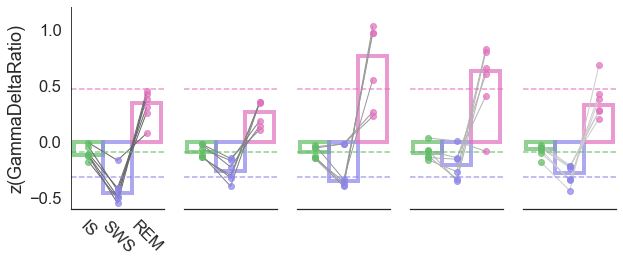

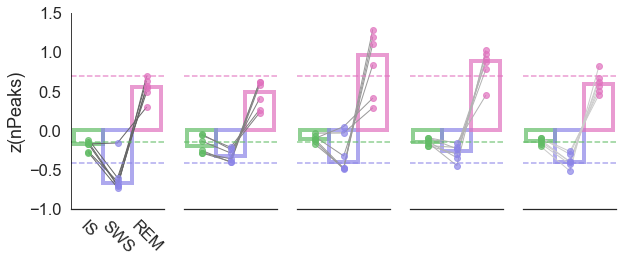

In [37]:
# Graph with horizontal line indicating mean across birds

for variable in ['DeltaLog', 'GammaDeltaRatio', 'nPeaks']:
    plt.figure(figsize=(9,4))

    for b_num in range(nBirds):
        b_name = 'Bird ' + str(b_num+1)
        Scores = AllScores[b_name]

        bird_Var_by_stage = pd.DataFrame([])

        for ch in channelsToLoadEEG[b_num]:

            ch_variables = SleepVariables[b_name + ': ' + ch].copy()

            bird_Var_by_stage[ch] = ch_variables.groupby(by='sleep scores').mean()[variable]

        plt.subplot(1,5,b_num+1)
        # lines color coded by bird
        plt.plot(bird_Var_by_stage, '-', color=colors_birds[b_num], alpha=1, linewidth=1)
        
        for st in [3,4,5]:
            # dots color coded by stage
            plt.plot(np.repeat(st, len(bird_Var_by_stage.columns)),
                     bird_Var_by_stage.loc[st], 'o', color=colors[st], alpha=.7)
            
            # bar graph of MEDIANS across channels
            plt.bar(st, np.nanmedian(bird_Var_by_stage.loc[st]),
                    width=1, color='none', edgecolor=colors[st], linewidth=4, alpha=.7)
            
            # dashed line of mean across all birds
            plt.axhline(grandmeans[variable].loc[st], linestyle='--', color=colors[st], alpha=.7)
        
        if variable=='DeltaLog':
            plt.ylim(-1, 0.75)
            plt.title('Bird ' + str(b_num+1), color=colors_birds[b_num])
        elif variable=='GammaDeltaRatio':
            plt.ylim(-.6, 1.2)
        else:
            plt.ylim(-1, 1.5)
        
        if b_num == 0:
            plt.ylabel('z(' + variable + ')')
            plt.xticks([3,4,5], ['IS', 'SWS', 'REM'], rotation=-45)
            plt.axvline(2.4, color='k')
        else:
            plt.yticks([])
            plt.xticks([])
            
        plt.xlim(2.4, 5.6)
        plt.tight_layout()
        sns.despine(left=True)
        
    if savePlots:
        plt.savefig(saveAsPath + saveAsName + '4f-g_totals_by_bird_' + variable + '.pdf')

### save to csv

In [38]:
if saveData:
    for variable in ['DeltaLog', 'GammaDeltaRatio', 'nPeaks']:
        for b_num in range(nBirds):
            b_name = 'Bird ' + str(b_num+1)
            Scores = AllScores[b_name]

            bird_Var_by_stage = pd.DataFrame([])

            for ch in channelsToLoadEEG[b_num]:

                ch_variables = SleepVariables[b_name + ': ' + ch].copy()

                bird_Var_by_stage[ch] = ch_variables.groupby(by='sleep scores').mean()[variable]
                
                bird_Var_by_stage.to_csv(saveAsPath + saveAsName + '4f-g_' + variable + '_' + b_name + '.csv')


# Line graphs by hour

## SWA

### individual birds

Text(0.5, 1.0, 'all sleep: individual birds')

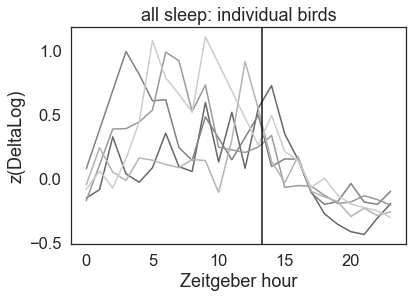

In [39]:
variable = 'DeltaLog'

SWA_by_hr = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch]

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
                
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    SWA_by_hr[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('all sleep: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_SWA_All_sleep_individual_birds.pdf')

Text(0.5, 1.0, 'NREM only: individual birds')

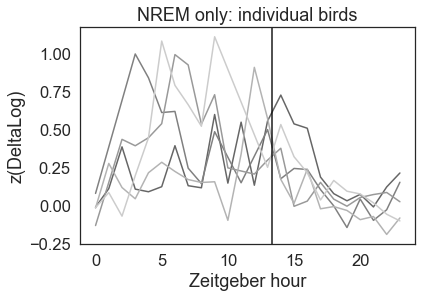

In [40]:

SWA_by_hr_NREMonly = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch].copy()

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
        
        # get NREM epochs only
        ch_variables = ch_variables[(ch_variables['sleep scores']==3)|
                                    (ch_variables['sleep scores']==4)]
        
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    SWA_by_hr_NREMonly[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('NREM only: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_SWA_NREM_only_individual_birds.pdf')

### Mean of all birds

Text(0.5, 1.0, 'SWA: all sleep')

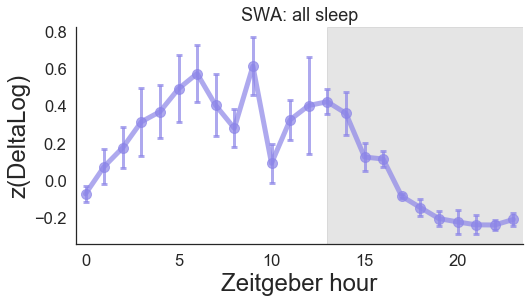

In [41]:
dataframe = SWA_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=colors[4], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(' + variable + ')', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('SWA: all sleep')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_SWA_All_sleep.pdf')

### FIGURE 4D: by-hour SWA

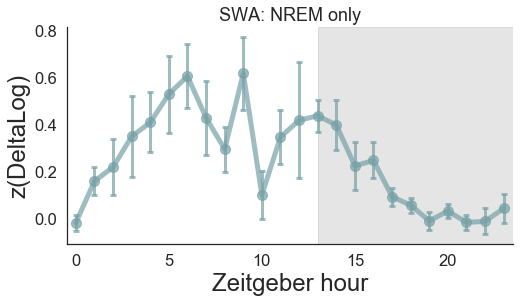

In [42]:
dataframe = SWA_by_hr_NREMonly

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(' + variable + ')', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('SWA: NREM only')

if savePlots:
    plt.savefig(saveAsPath + saveAsName + '4d_SWA_NREM_only.pdf')

### save to csv

In [43]:
if saveData:
    dataframe.to_csv(saveAsPath + saveAsName + '4d_SWA-by-hour_NREM_only.csv')

### FIGURE 4D STATS

In [44]:
print('SWA (all sleep): nighttime')
dataframe = SWA_by_hr
Means = dataframe[13:24].mean(axis=1) # nighttime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

SWA (all sleep): nighttime
slope = -0.0678677116021243 , r2 = 0.8318753003162749 , p = 9.128388730181508e-05


In [45]:
print('SWA (NREM only): nighttime')
dataframe = SWA_by_hr_NREMonly
Means = dataframe[13:24].mean(axis=1) # nighttime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

SWA (NREM only): nighttime
slope = -0.04418573546019022 , r2 = 0.786494897630052 , p = 0.00027355732980362317


In [46]:
print('SWA (all sleep): morning')
dataframe = SWA_by_hr
Means = dataframe[0:6].mean(axis=1) # first half of daytime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

SWA (all sleep): morning
slope = 0.10624355085205056 , r2 = 0.9901042560538514 , p = 3.319258210796676e-06


In [47]:
print('SWA (NREM only): morning')
dataframe = SWA_by_hr_NREMonly
Means = dataframe[0:6].mean(axis=1) # first half of daytime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

SWA (NREM only): morning
slope = 0.09991161473670075 , r2 = 0.9852828413423813 , p = 8.968817801891954e-06


## Gamma/delta

### individual birds

Text(0.5, 1.0, 'all sleep: individual birds')

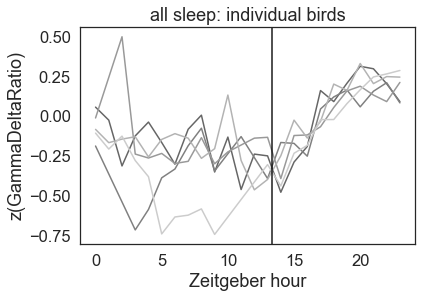

In [48]:
variable = 'GammaDeltaRatio'

Gamma_by_hr = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch]

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
                
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    Gamma_by_hr[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('all sleep: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4_GammaDelta_All_sleep_individual_birds.pdf')

Text(0.5, 1.0, 'NREM only: individual birds')

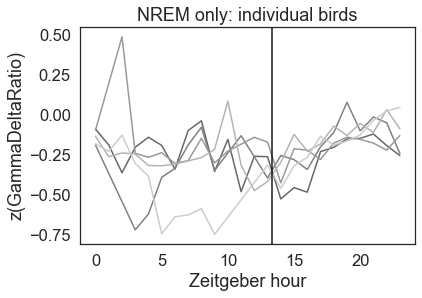

In [49]:

Gamma_by_hr_NREMonly = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch].copy()

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
        
        # get NREM epochs only
        ch_variables = ch_variables[(ch_variables['sleep scores']==3)|
                                    (ch_variables['sleep scores']==4)]
        
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    Gamma_by_hr_NREMonly[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('NREM only: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4_GammaDelta_NREM_only_individual_birds.pdf')

### Mean of all birds

Text(0.5, 1.0, 'Gamma/delta: all sleep')

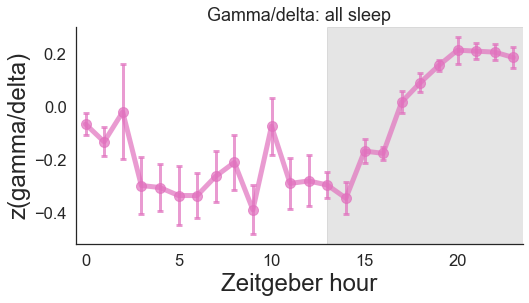

In [50]:
dataframe = Gamma_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=colors[5], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(gamma/delta)', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('Gamma/delta: all sleep')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + variable + '4_All_sleep.pdf')

### stats

In [51]:
print('z(gamma/delta) (all sleep): nighttime')
dataframe = Gamma_by_hr
Means = dataframe[13:24].mean(axis=1) # nighttime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

z(gamma/delta) (all sleep): nighttime
slope = 0.06042714547018966 , r2 = 0.8688292828935021 , p = 2.9361411190112645e-05


### save to csv

In [52]:
if saveData:
    dataframe.to_csv(saveAsPath + saveAsName + '4d_Gamma-delta-ratio_by-hour_all_sleep.csv')

Text(0.5, 1.0, 'Gamma/delta: NREM only')

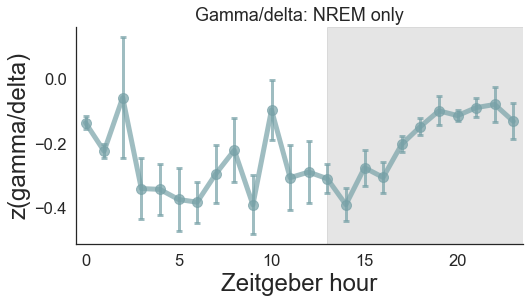

In [53]:
dataframe = Gamma_by_hr_NREMonly

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(gamma/delta)', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('Gamma/delta: NREM only')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + variable + '4_NREM_only.pdf')

## nPeaks

### individual birds

Text(0.5, 1.0, 'all sleep: individual birds')

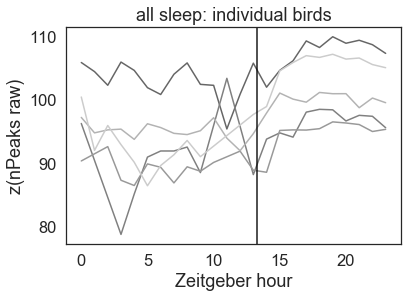

In [54]:
variable = 'nPeaks raw'

nPeaks_by_hr = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch]

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
                
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    nPeaks_by_hr[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('all sleep: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4e_nPeaks_All_sleep_individual_birds.pdf')

### Mean of all birds

Text(0.5, 1.0, 'nPeaks: all sleep')

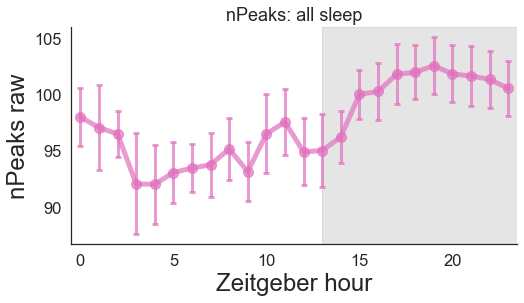

In [55]:
dataframe = nPeaks_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=colors[5], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel(variable, fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('nPeaks: all sleep')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + variable + '4e_All_sleep.pdf')

### Mean of all birds -- zscore

Text(0.5, 1.0, 'all sleep: individual birds')

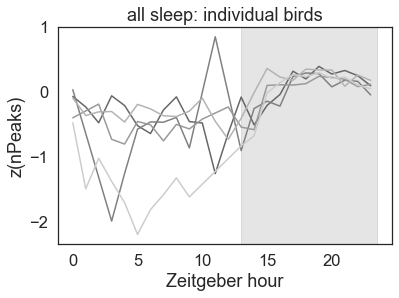

In [56]:
variable = 'nPeaks'

nPeaks_by_hr = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch]

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
                
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    nPeaks_by_hr[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('all sleep: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4e_nPeaks_All_sleep_individual_birds.pdf')

### FIGURE 4E: by-hour nPeaks

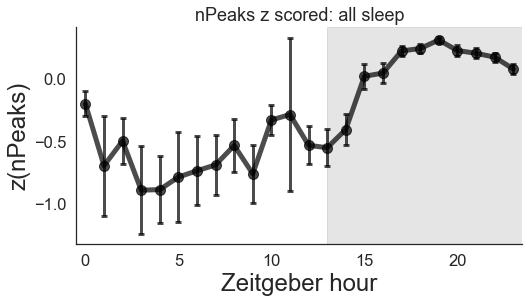

In [58]:
dataframe = nPeaks_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color='k', figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(' + variable + ')', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('nPeaks z scored: all sleep')

if savePlots:
    plt.savefig(saveAsPath + saveAsName + '4e_' + variable + '_All_sleep.pdf')

### FIGURE 4E STATS

In [59]:
print('z(nPeaks) (all sleep): nighttime')
dataframe = nPeaks_by_hr
Means = dataframe[13:24].mean(axis=1) # nighttime hours

test=Means.dropna()

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)

print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

z(nPeaks) (all sleep): nighttime
slope = 0.058821035789737165 , r2 = 0.4904401472321173 , p = 0.016401758418720457


### save to csv

In [60]:
if saveData:
    dataframe.to_csv(saveAsPath + saveAsName + '4e_nPeaks-by-hour_all_sleep.csv')

### NREM only

Text(0.5, 1.0, 'NREM only: individual birds')

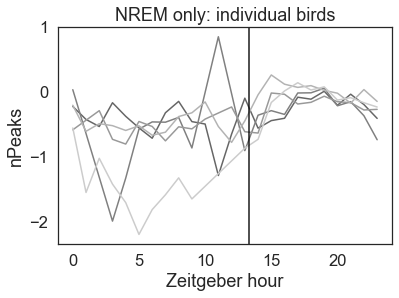

In [61]:

nPeaks_by_hr_NREMonly = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]:

        ch_variables = SleepVariables[b_name + ': ' + ch].copy()

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
        
        # get NREM epochs only
        ch_variables = ch_variables[(ch_variables['sleep scores']==3)|
                                    (ch_variables['sleep scores']==4)]
        
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    nPeaks_by_hr_NREMonly[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel(variable)
plt.title('NREM only: individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_nPeaks_NREM_only_individual_birds.pdf')

Text(0.5, 1.0, 'nPeaks: NREM only')

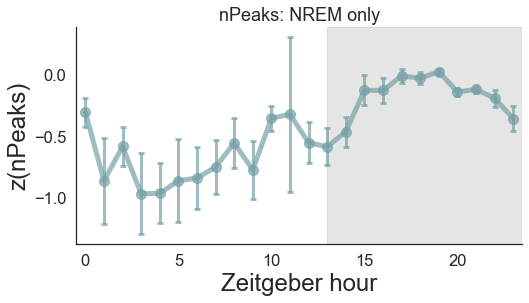

In [62]:
dataframe = nPeaks_by_hr_NREMonly

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(' + variable + ')', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(round(np.mean(lightsOffZeit_hr)) + 24, 23.5, color='k', alpha=.1)
plt.title('nPeaks: NREM only')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + variable + '4d_NREM_only.pdf')

# Comparisons

## TST

### TST by hour

Text(0.5, 1.0, 'individual birds')

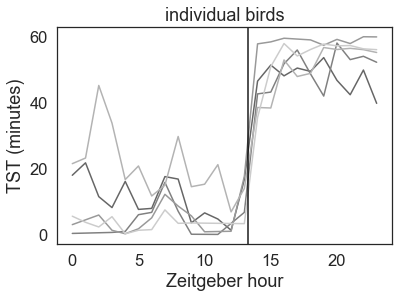

In [63]:

TST_by_hour = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])

    z_hours = Scores['Zeitgeber time (h)'].copy()
    z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

    z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
    Scores['Z hours rounded'] = z_hours_round

    # arrange Zeitgeber hours by epoch
    Z_hours_by_ep = Scores[['Z hours rounded','Epoch #', 'Label (#)']].copy()

    # make sure to get sleep epochs only
    Z_hours_by_ep = Z_hours_by_ep[Z_hours_by_ep['Label (#)']>2]

    # get the number of TST epochs in each Zeitgeber hour
    var_by_hr = Z_hours_by_ep.groupby('Z hours rounded').count()['Epoch #']*3/60
        
    # plot for each bird
    plt.plot(var_by_hr, color=colors_birds[b_num]) 
    
    # save to dataframe
    TST_by_hour[b_name] = var_by_hr
    
# change NaN's to 0
TST_by_hour = TST_by_hour.fillna(0)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('TST (minutes)')
plt.title('individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_TST_by_hr_individual_birds.pdf')

### FIGURE 4D: by-hour TST

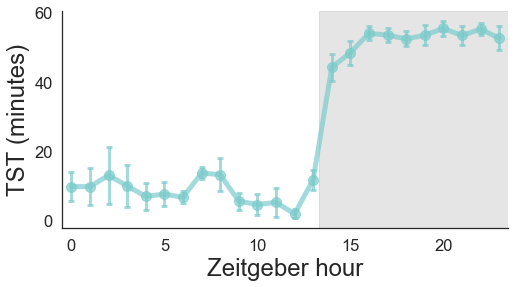

In [64]:
dataframe = TST_by_hour

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=colors_video[5], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('TST (minutes)', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(np.mean(lightsOffZeit_hr) + 24, 23.5, color='k', alpha=.1)

if savePlots:
    plt.savefig(saveAsPath + saveAsName + '4d_TST_by_hour.pdf')

### save to csv

In [65]:
if saveData:
    dataframe.to_csv(saveAsPath + saveAsName + '4d_TST-by-hour_all_sleep.csv')

### TST vs SWA for each bird

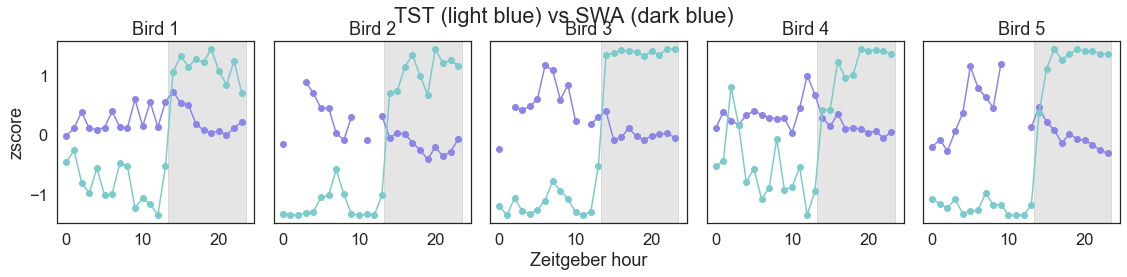

In [66]:
plt.figure(figsize=(16,4))
for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    
    color = colors_birds[b_num]

    plt.subplot(1, nBirds, b_num+1)
    plt.plot(SWA_by_hr_NREMonly[b_name], color=colors[4], marker='o')
    plt.plot(stat.zscore(TST_by_hour[b_name]), color=colors_video[5], marker='o')
    
    plt.axvspan(np.mean(lightsOffZeit_hr) + 24, 23.5, color='k', alpha=.1)
    
    plt.title(b_name)
    
    if b_num==0:
        plt.ylabel('zscore')
    else:
        plt.yticks([])

    if b_num==2:
        plt.xlabel('Zeitgeber hour')
        
plt.suptitle('TST (light blue) vs SWA (dark blue)')
plt.tight_layout()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4e_TST_vs_SWA_individual_birds.pdf')

# NREM amount

### NREM by hour

Text(0.5, 1.0, 'individual birds')

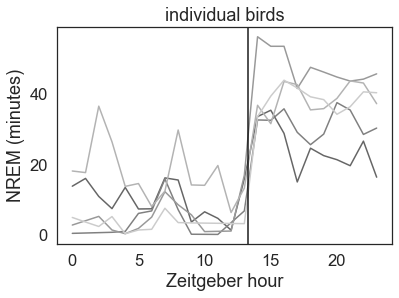

In [67]:

NREM_by_hour = pd.DataFrame([])

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])

    z_hours = Scores['Zeitgeber time (h)'].copy()
    z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

    z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
    Scores['Z hours rounded'] = z_hours_round

    # arrange Zeitgeber hours by epoch
    Z_hours_by_ep = Scores[['Z hours rounded','Epoch #', 'Label (#)']].copy()

    # make sure to get sleep epochs only
    Z_hours_by_ep = Z_hours_by_ep[(Z_hours_by_ep['Label (#)']==3)|
                                  (Z_hours_by_ep['Label (#)']==4)]

    # get the number of TST epochs in each Zeitgeber hour
    var_by_hr = Z_hours_by_ep.groupby('Z hours rounded').count()['Epoch #']*3/60
        
    # plot for each bird
    plt.plot(var_by_hr, color=colors_birds[b_num]) 
    
    # save to dataframe
    NREM_by_hour[b_name] = var_by_hr
    
# change NaN's to 0
NREM_by_hour = NREM_by_hour.fillna(0)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('NREM (minutes)')
plt.title('individual birds')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_NREM_by_hr_individual_birds.pdf')

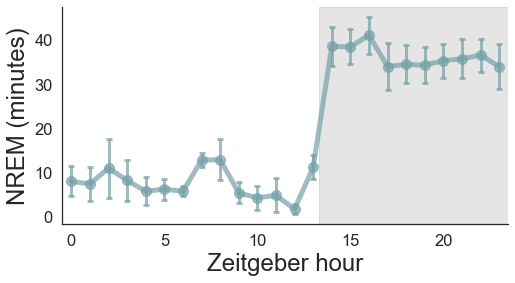

In [68]:
dataframe = NREM_by_hour

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('NREM (minutes)', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvspan(np.mean(lightsOffZeit_hr) + 24, 23.5, color='k', alpha=.1)

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_NREM_by_hour.pdf')

### TST vs SWA for each bird

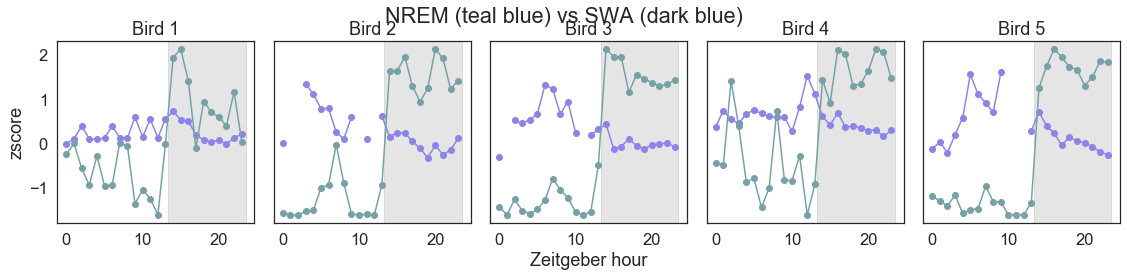

In [69]:
plt.figure(figsize=(16,4))
for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    
    color = colors_birds[b_num]

    plt.subplot(1, nBirds, b_num+1)
    plt.plot(SWA_by_hr_NREMonly[b_name], color=colors[4], marker='o')
    plt.plot(stat.zscore(NREM_by_hour[b_name]), color=NREM_color, marker='o')
    
    plt.axvspan(np.mean(lightsOffZeit_hr) + 24, 23.5, color='k', alpha=.1)
    
    plt.title(b_name)
    
    if b_num==0:
        plt.ylabel('zscore')
    else:
        plt.yticks([])

    if b_num==2:
        plt.xlabel('Zeitgeber hour')
        
plt.suptitle('NREM (teal blue) vs SWA (dark blue)')
plt.tight_layout()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + '4d_individual_birds.pdf')

# LL

## get channels that were good through both LD and LL

In [70]:
# LL: channels that were still good
channelsToLoadEEG_LL = [['5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '9 REEGf-REEGm'], # BIRD 2 bad ch: '4 LEEGf-Fgr', '7 REEGf-Fgr', '8 REEGm-Fgr',
                        ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                        ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr','9REEGf-REEGp']] # BIRD 4 bad ch: '8REEGf-REEGm'


## SWA

In [71]:
channelsToLoadEEG_best[1:4]

[['5 LEEGf-LEEGm', '4 LEEGf-Fgr'],
 ['6LEEGm-LEEGp', '9REEGm-REEGp'],
 ['9REEGf-REEGp', '6LEEGm-LEEGf']]

Text(0.5, 1.0, 'LL all sleep: individual birds')

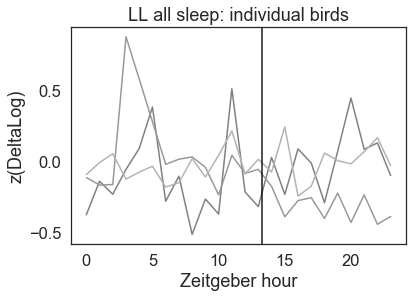

In [72]:
variable = 'DeltaLog'

LL_SWA_by_hr = pd.DataFrame([])

for b_num in birds_LL:
    b_name = 'Bird ' + str(b_num+1) + 'LL'
    Scores = AllScores_LL[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])
    
    for ch in channelsToLoadEEG_best[b_num]: # only use the two best channels 
                                             # -- for all 3 LL birds these were intact in LL

        ch_variables = SleepVariables[b_name + ': ' + ch]

        z_hours = Scores['Zeitgeber time (h)'].copy()
        z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

        z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
        Scores['Z hours rounded'] = z_hours_round

        # arrange Zeitgeber hours by epoch, merge with sleep spectral variables dataframe
        Z_hours_by_ep = Scores[['Z hours rounded','Epoch #']].copy()
        Z_hours_by_ep['Epoch'] = Scores['Epoch #']
        ch_variables = pd.merge(ch_variables, Z_hours_by_ep, on='Epoch')
                
        # get the mean of the designated variable in each Zeitgeber hour
        var_by_hr = ch_variables.groupby('Z hours rounded').mean()[variable]
        # save to by-bird dataframe
        bird_Var_by_hr[ch] = var_by_hr
        
    # plot mean of channels for each bird
    plt.plot(np.mean(bird_Var_by_hr, axis=1), color=colors_birds[b_num]) 
    
    # save means for each bird to dataframe
    LL_SWA_by_hr[b_name] = np.mean(bird_Var_by_hr, axis=1)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('z(' + variable + ')')
plt.title('LL all sleep: individual birds')

#if savePlots:
#    plt.savefig('./Fig 09/' + saveAsName + '9_All_sleep_individual_birds_LL.pdf')

### FIGURE 9F: by-hour SWA in LL vs LD

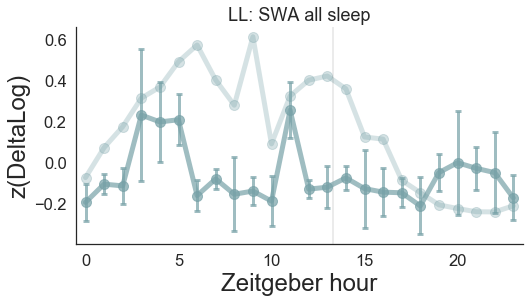

In [73]:
dataframe = LL_SWA_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

dataframe = SWA_by_hr

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(color=NREM_color, figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.3,
                        legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('z(' + variable + ')', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.1)
plt.title('LL: SWA all sleep')

if savePlots:
    plt.savefig('./Fig 09/' + saveAsName + '9f_SWA_all_sleep_LLvLD.pdf')

### save to csv

In [74]:
if saveData:
    dataframe = LL_SWA_by_hr
    dataframe.to_csv('./Fig 09/' + saveAsName + '9f_SWA-by-hour_all_sleep_LL.csv')
    
    dataframe = SWA_by_hr
    dataframe.to_csv('./Fig 09/' + saveAsName + '9f_SWA-by-hour_all_sleep_LD.csv')

In [75]:
saveAsPath

'./Fig 04/'

## TST

### TST by hour

Text(0.5, 1.0, 'individual birds')

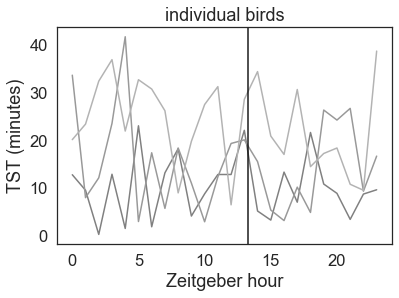

In [76]:

TST_by_hour_LL = pd.DataFrame([])

for b_num in birds_LL:
    b_name = 'Bird ' + str(b_num+1) + 'LL'
    Scores = AllScores_LL[b_name]
    
    bird_Var_by_hr = pd.DataFrame([])

    z_hours = Scores['Zeitgeber time (h)'].copy()
    z_hours[z_hours<0] += 24    # adjust negative Zeitgeber hours to positive

    z_hours_round = np.floor(z_hours)   # round down to nearest Zeitgeber hour
    Scores['Z hours rounded'] = z_hours_round

    # arrange Zeitgeber hours by epoch
    Z_hours_by_ep = Scores[['Z hours rounded','Epoch #', 'Video Label (#)']].copy()

    # make sure to get sleep epochs only
    Z_hours_by_ep = Z_hours_by_ep[Z_hours_by_ep['Video Label (#)']>2]

    # get the number of TST epochs in each Zeitgeber hour
    var_by_hr = Z_hours_by_ep.groupby('Z hours rounded').count()['Epoch #']*3/60
        
    # plot for each bird
    plt.plot(var_by_hr, color=colors_birds[b_num]) 
    
    # save to dataframe
    TST_by_hour_LL[b_name] = var_by_hr
    
# change NaN's to 0
TST_by_hour_LL = TST_by_hour_LL.fillna(0)
    
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.9)
    
plt.xlabel('Zeitgeber hour')
plt.ylabel('TST (minutes)')
plt.title('individual birds')

#if savePlots:
#    plt.savefig('./Fig 09/' + saveAsName + '9_TST_by_hr_individual_birds_LL.pdf')

### FIGURE 9G: by-hour TST in LL vs LD

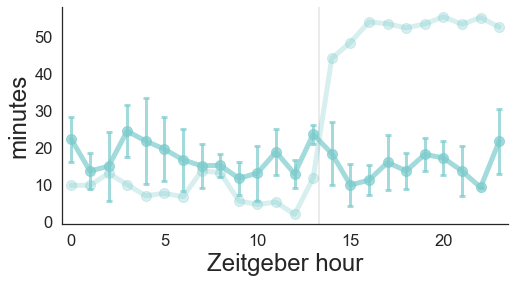

In [77]:
dataframe = TST_by_hour_LL

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(yerr=SEMs, color=colors_video[5], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.7,
                        capsize=3, capthick=3,
                        elinewidth=3, legend='')

dataframe = TST_by_hour

Means = dataframe.mean(axis=1)
SEMs  = dataframe.std(axis=1)/(np.sqrt(dataframe.count(axis=1)))

Means.plot(color=colors_video[5], figsize=(8,4), 
                        marker='o', markersize=10,
                        linewidth=5, alpha=0.3,
                        legend='')

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('minutes', fontsize=axis_label_fontsize)
plt.xlim(-.5, 23.5)
sns.despine()
plt.axvline(np.mean(lightsOffZeit_hr) + 24, color='k', alpha=.1)

if savePlots:
    plt.savefig('./Fig 09/' + saveAsName + '9g_TST_all_sleep_LLvLD.pdf')

### save to csv

In [78]:
if saveData:
    dataframe = LL_SWA_by_hr
    dataframe.to_csv('./Fig 09/' + saveAsName + '9g_TST-by-hour_all_sleep_LL.csv')

### TST vs SWA for each bird

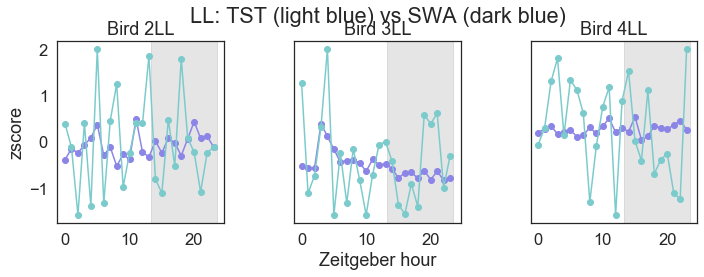

In [79]:
plt.figure(figsize=(16,4))
for b_num in birds_LL:
    b_name = 'Bird ' + str(b_num+1) + 'LL'
    
    color = colors_birds[b_num]

    plt.subplot(1, nBirds, b_num+1)
    plt.plot(LL_SWA_by_hr[b_name], color=colors[4], marker='o')
    plt.plot(stat.zscore(TST_by_hour_LL[b_name]), color=colors_video[5], marker='o')
    
    plt.axvspan(np.mean(lightsOffZeit_hr) + 24, 23.5, color='k', alpha=.1)
    
    plt.title(b_name)
    
    if b_num==1:
        plt.ylabel('zscore')
    else:
        plt.yticks([])

    if b_num==2:
        plt.xlabel('Zeitgeber hour')
        
plt.suptitle('LL: TST (light blue) vs SWA (dark blue)')
plt.tight_layout()

#if savePlots:
#    plt.savefig('./Fig 09/' + saveAsName + '9_TST_vs_SWA_individual_birds_LL.pdf')